## Import libraries, methods and constants

In [1]:
import numpy as np
import cv2
import os
from os import sys
import json
import codecs

In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from constants import annotation_folder, image_filenames, weed_indices, crop_indices, plant_classification
from data_visualization import plot_ground_truth_annotation, plot_annotation_for_image, use_one_channel

## Visualize annotation

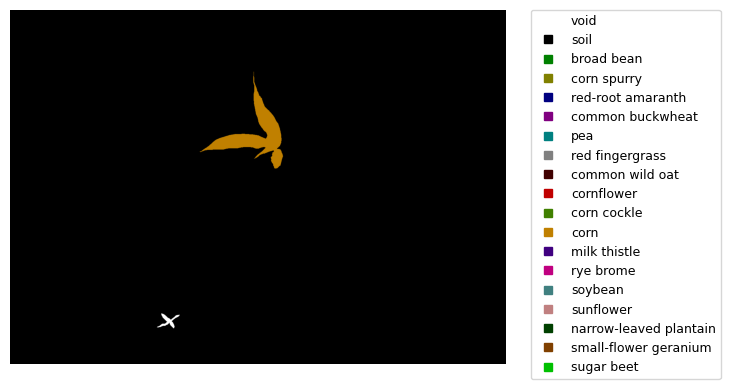

In [3]:
plot_ground_truth_annotation('img_00000.png')

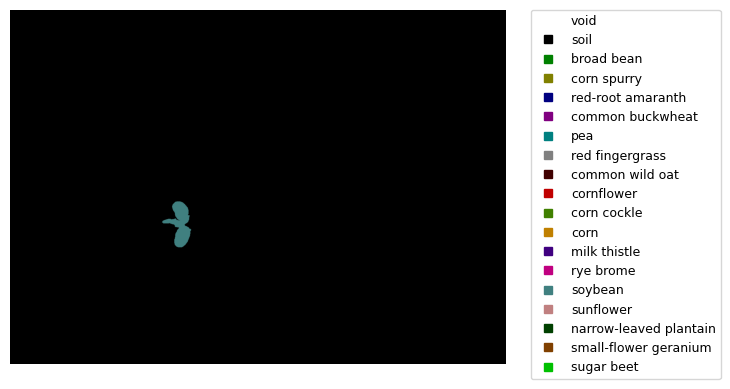

In [4]:
plot_ground_truth_annotation('img_00045.png')

## Change classes in annotation mask

In [5]:
def swap_classes(class_pairs, image_name):
    im = cv2.imread(annotation_folder + image_name)

    return swap_classes_for_image(class_pairs, im)
    
def swap_classes_for_image(class_pairs, im):
    for old_class, new_class in class_pairs:
        # Create a mask to identify pixels with the old class
        mask = (im[:, :, 0] == old_class)

        # Replace the matching pixels with the new class value
        im[mask, :] = new_class

    return im

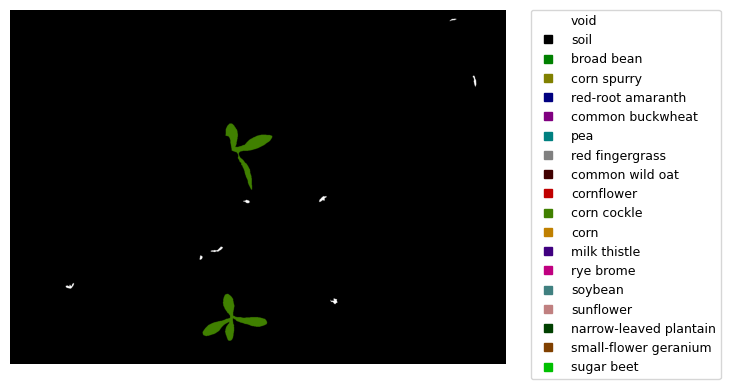

In [6]:
plot_ground_truth_annotation('img_01109.png')

[ 1 10]


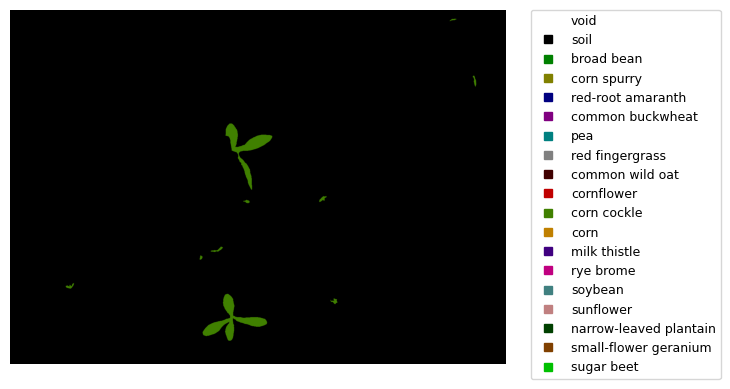

In [7]:
im = swap_classes([(0, 10)], 'img_01109.png')
print(np.unique(im))
plot_annotation_for_image(im)

## Generate new annotation masks for each model

The model expects as input class labels that are have indexes in natural order. Therefore, we have to reindex labels for specific plants for each model. Generally, "0" will always be void index (plants that cannot be classified yet), "1" will point to soil and "2" will point to the crop that is currently considered by the model. In case of a binary model "3" will indicate an aggregated "weeds" class. And in case of a multiclass model the weeds will be indexed beginning from "3", resultig in weed 1 having index "3", weed 2 having index "4", weed 3 having index "5" and so on.

In [9]:
from constants import weed_indices_to_exclude_from_models_filepath

weed_indices_to_exclude = json.load(codecs.open(weed_indices_to_exclude_from_models_filepath, 'r', 'utf-8-sig'))
weed_indices_to_consider = [x for x in weed_indices if x not in weed_indices_to_exclude]
weed_indices_to_consider

[9, 10, 12, 13, 17]

In [10]:
# Class swapping for binary models
from constants import annotations_binary_folder

weed_swap_class_list = [(x, 3) for x in weed_indices_to_consider]
print(weed_swap_class_list)

for crop_index in crop_indices:
    for image_filename in image_filenames:
        folder_path = annotations_binary_folder + list(plant_classification.keys())[crop_index].replace(" ", "_")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        image_path = folder_path + '/' + image_filename
        if not os.path.isfile(image_path):
            im = swap_classes([(crop_index, 2)] + weed_swap_class_list, image_filename)
            cv2.imwrite(image_path, use_one_channel(im))

[(9, 3), (10, 3), (12, 3), (13, 3), (17, 3)]


In [11]:
# Class swapping for multi-class models
from constants import annotations_multiclass_folder

weed_swap_class_list = [(weed_index, 3 + i) for i, weed_index in enumerate(weed_indices_to_consider)]
print(weed_swap_class_list)

for crop_index in crop_indices:
    for image_filename in image_filenames:
        folder_path = annotations_multiclass_folder + list(plant_classification.keys())[crop_index].replace(" ", "_")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        image_path = folder_path + '/'  + image_filename
        if not os.path.isfile(image_path):
            im = swap_classes([(crop_index, 2)] + weed_swap_class_list, image_filename)
            cv2.imwrite(image_path, use_one_channel(im))

[(9, 3), (10, 4), (12, 5), (13, 6), (17, 7)]
